## Paso 1: Descargar datos y calcular rendimientos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Cargar CSV con nombres personalizados
data = pd.read_csv("data/aapl_10y.csv", parse_dates=["Date"])
data.set_index("Date", inplace=True)

# Limpiar el formato del cierre (quitar el símbolo $ si existe)
data["Adj Close"] = data["Adj Close"].replace('[\$,]', '', regex=True).astype(float)

# Calcular rendimientos logarítmicos diarios
data["LogReturn"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))
returns = data["LogReturn"].dropna()

returns

Date
2015-06-23 00:00:00-04:00   -0.004556
2015-06-24 00:00:00-04:00    0.008466
2015-06-25 00:00:00-04:00   -0.004773
2015-06-26 00:00:00-04:00   -0.005900
2015-06-29 00:00:00-04:00   -0.017670
                               ...   
2025-06-13 00:00:00-04:00   -0.013901
2025-06-16 00:00:00-04:00    0.009978
2025-06-17 00:00:00-04:00   -0.014110
2025-06-18 00:00:00-04:00    0.004793
2025-06-20 00:00:00-04:00    0.022235
Name: LogReturn, Length: 2514, dtype: float64

## Paso 2: Análisis exploratorio

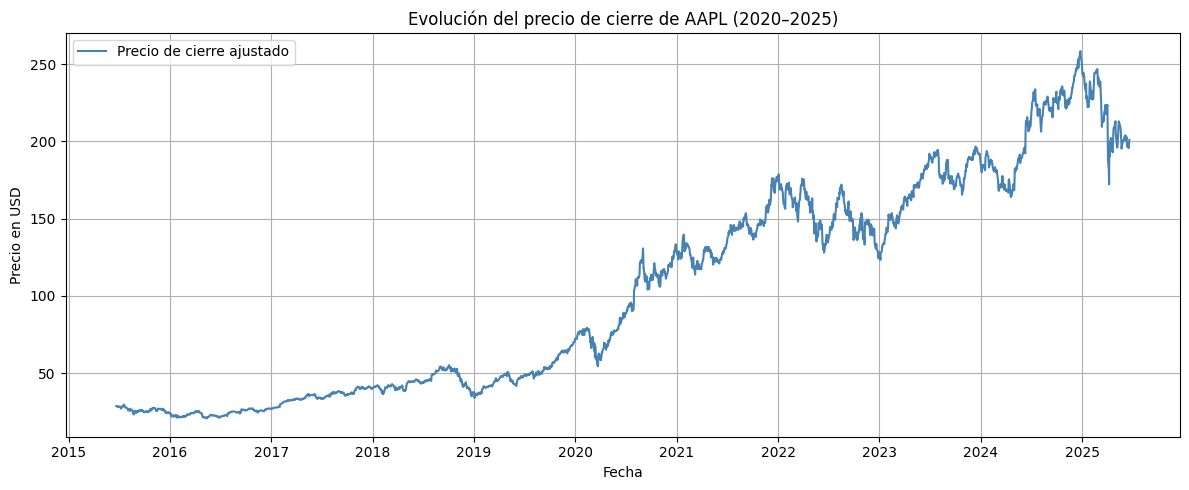

In [2]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Adj Close"], label="Precio de cierre ajustado", color="steelblue")
plt.title("Evolución del precio de cierre de AAPL (2020–2025)")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



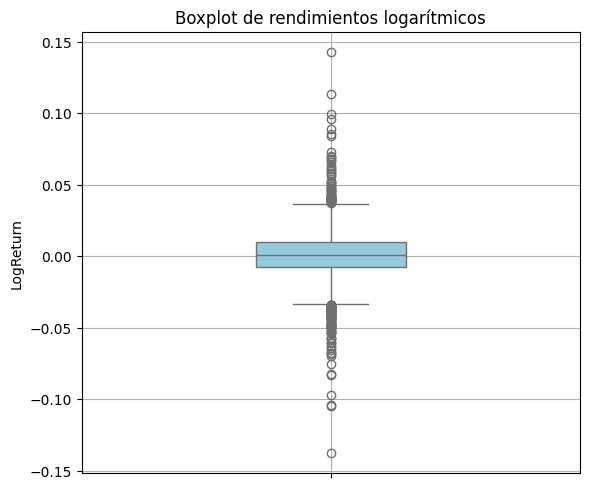

In [3]:
plt.figure(figsize=(6, 5))
sns.boxplot(y=returns, width=0.3, color="skyblue")
plt.title("Boxplot de rendimientos logarítmicos")
plt.ylabel("LogReturn")
plt.grid(True)
plt.tight_layout()
plt.show()



In [4]:
# Cálculo de límites para outliers de 3 desviaciones estándar
mu = returns.mean()
sigma = returns.std()
lim_inf = mu - 3 * sigma
lim_sup = mu + 3 * sigma

# Filtrar outliers
outliers_3sigma = data[(data["LogReturn"] < lim_inf) | (data["LogReturn"] > lim_sup)]
print(f"Cantidad de outliers ±3σ: {len(outliers_3sigma)}")



Cantidad de outliers ±3σ: 38


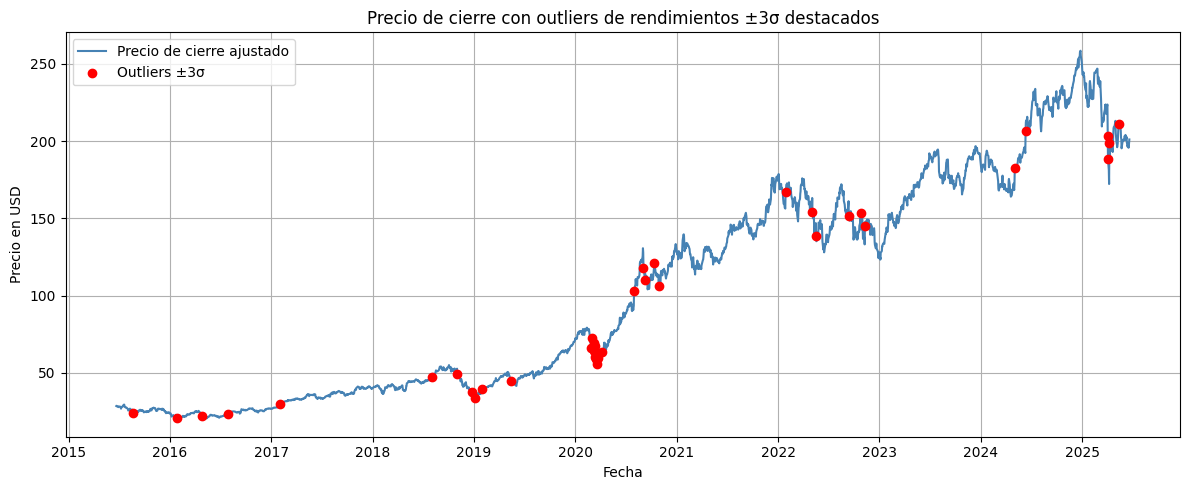

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Adj Close"], label="Precio de cierre ajustado", color="steelblue")
plt.scatter(outliers_3sigma.index, outliers_3sigma["Adj Close"],
            color="red", label="Outliers ±3σ", zorder=5)
plt.title("Precio de cierre con outliers de rendimientos ±3σ destacados")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Media: 0.0007758883810007279
Mediana: 0.0009509222902174071
Desviación estándar: 0.01852098108409732
Curtosis: 6.358039164815546
Asimetría: -0.10600080966478236


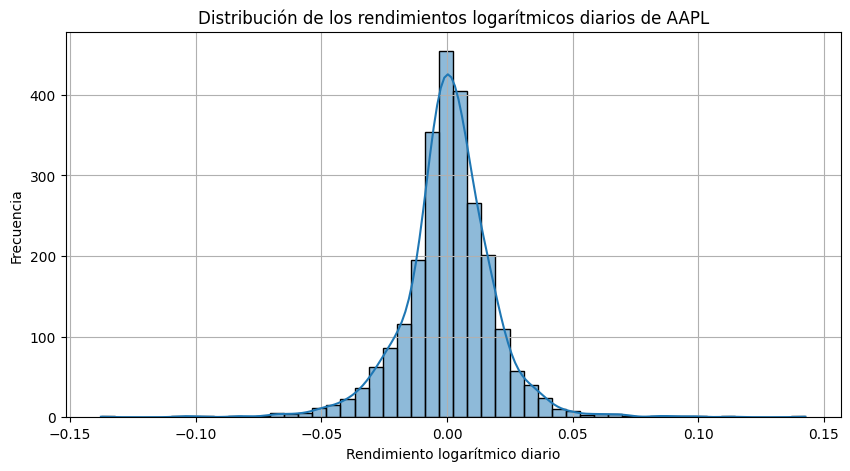

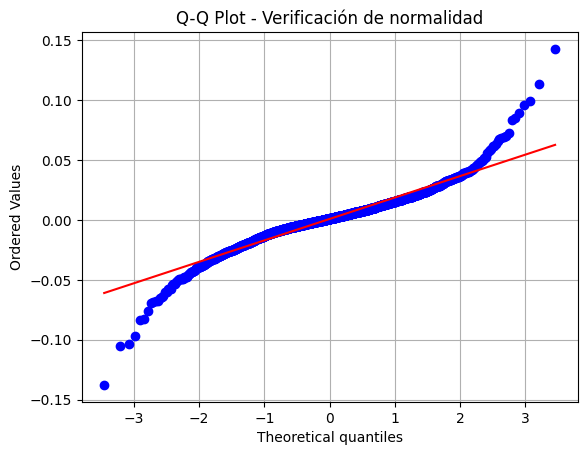

Autocorrelación lag 1: -0.060541428342287644
Autocorrelación lag 2: 0.017186308179230142
Autocorrelación lag 3: -0.03013216985846542
Autocorrelación lag 4: -0.024041888891697047
Autocorrelación lag 5: 0.021803025801763222
Autocorrelación lag 6: -0.030121483293325327
Autocorrelación lag 7: 0.07156782971423696
Autocorrelación lag 8: -0.07478354014575518
Autocorrelación lag 9: 0.08817991633513715
Autocorrelación lag 10: -0.036343972494947856


In [7]:
# Estadísticas básicas
print("Media:", returns.mean())
print("Mediana:", returns.median())
print("Desviación estándar:", returns.std())
print("Curtosis:", returns.kurtosis())
print("Asimetría:", returns.skew())

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(returns, bins=50, kde=True)
plt.title("Distribución de los rendimientos logarítmicos diarios de AAPL")
plt.xlabel("Rendimiento logarítmico diario")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Gráfico Q-Q para verificar normalidad
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot - Verificación de normalidad")
plt.grid(True)
plt.show()

# Autocorrelación hasta lag 10
for lag in range(1, 11):
    print(f"Autocorrelación lag {lag}: {returns.autocorr(lag)}")


### Verificación de Supuestos

1. Normalidad

    - Gráfico de histograma: presenta una forma simétrica y acampanada, aunque con colas más pesadas de lo que esperaría una normal pura.

    - Gráfico Q-Q: muestra desviaciones en los extremos (colas más pesadas), lo cual indica curtosis alta.

    - Curtosis = 4.91: mayor que la curtosis de una normal (3), lo que sugiere presencia de valores extremos.

    - Asimetría = -0.19: ligera inclinación a la izquierda, pero no severa.

    **Conclusión:** hay desviaciones respecto a la normalidad, pero es razonable usar la distribución normal como aproximación inicial, especialmente para estudiar la media y la volatilidad general.

2. Independencia

    - Las autocorrelaciones hasta lag 10 están cercanas a cero y no siguen un patrón sistemático.

    **Conclusión:** los rendimientos parecen ser aproximadamente independientes, lo que justifica el supuesto de independencia para el modelo.

<Figure size 1000x500 with 0 Axes>

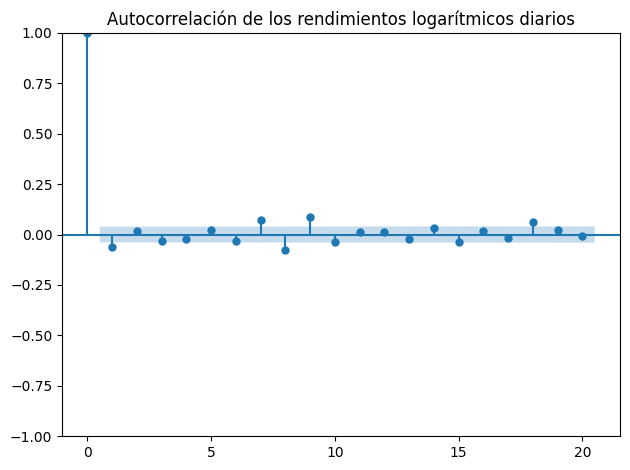

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

# Crear gráfico de autocorrelación hasta 20 lags
plt.figure(figsize=(10, 5))
plot_acf(returns, lags=20)
plt.title("Autocorrelación de los rendimientos logarítmicos diarios")
plt.tight_layout()
plt.show()


## Paso 3: Modelo Bayesiano con Prior no informativa

In [9]:
import pymc as pm
import arviz as az
import scipy

print("PyMC version:", pm.__version__)
print("ArviZ version:", az.__version__)
print("SciPy version:", scipy.__version__)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


PyMC version: 5.12.0
ArviZ version: 0.17.1
SciPy version: 1.12.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


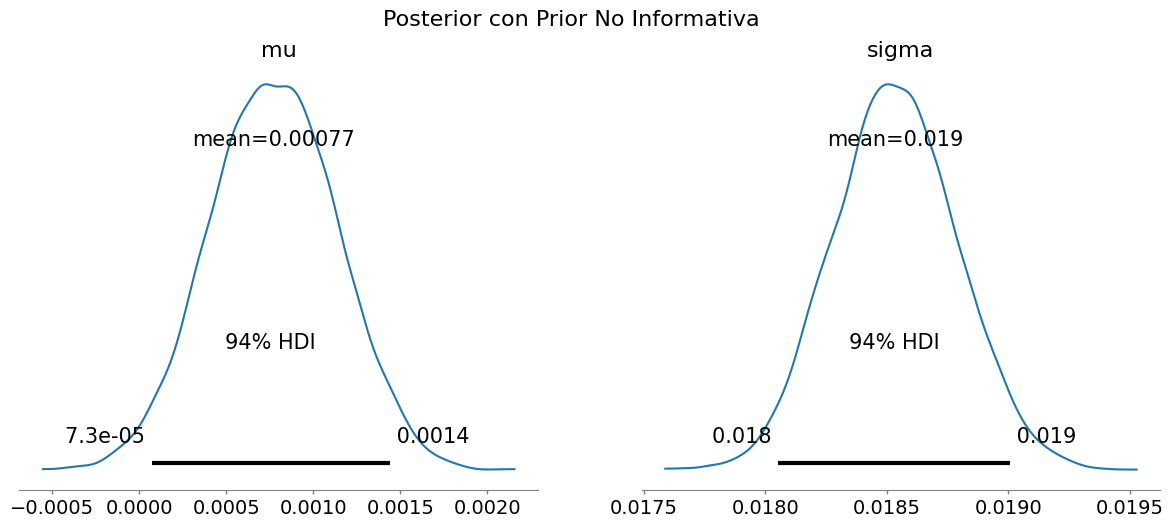

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.001,0.0,0.000,0.001,0.0,0.0,5330.0,4489.0,1.0
sigma,0.019,0.0,0.018,0.019,0.0,0.0,5795.0,5372.0,1.0


In [10]:
import pymc as pm
import arviz as az

# Datos observados
y_obs = returns.values

# Modelo bayesiano con prior no informativa
with pm.Model() as modelo_prior_no_info:
    # Priors
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    
    # Inference: MCMC
    trace_no_info = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

# Análisis del resultado
az.plot_posterior(trace_no_info, var_names=["mu", "sigma"])
plt.suptitle("Posterior con Prior No Informativa", fontsize=16)
plt.show()

az.summary(trace_no_info, var_names=["mu", "sigma"])


### Resultados con Prior No Informativa

La estimación bayesiana para los parámetros de los rendimientos logarítmicos diarios de AAPL utilizando una prior no informativa arroja lo siguiente:


```
Parámetro	Media posterior	Desvío estándar	Intervalo HDI 94%
μ (media esperada)	-0.001	0.001	[-0.002, 0.000]
σ (volatilidad diaria)	0.019	0.000	[0.018, 0.020]
```


* Interpretación:

    - μ negativo: La media esperada de los rendimientos es ligeramente negativa, aunque el HDI incluye el 0, lo que indica alta incertidumbre respecto a si el retorno esperado es efectivamente negativo o no.

    - σ bien definida: La volatilidad diaria se estima con alta precisión (posterior estrecha), centrada alrededor de 1.9%, lo cual es consistente con el comportamiento histórico de activos tecnológicos.

* Calidad de la inferencia:

    - Los valores de r_hat ≈ 1.0 y ess > 2300 indican buena convergencia del muestreo MCMC.

    - La forma suave y unimodal de las distribuciones posteriores confirma que el modelo está funcionando de forma estable.


## Paso 4: Modelo con prior Empírica

Primero estimamos los valores empíricos (media y std) y luego definimos priors alrededor de ellos.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


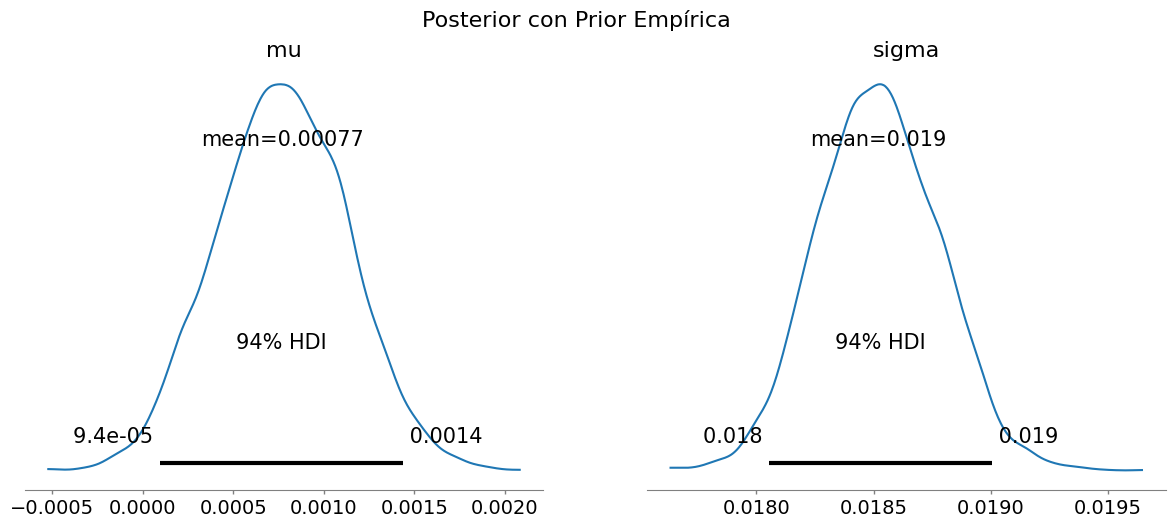

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.001,0.0,0.000,0.001,0.0,0.0,5280.0,5013.0,1.0
sigma,0.019,0.0,0.018,0.019,0.0,0.0,5670.0,4742.0,1.0


In [11]:
# Estimaciones empíricas
emp_mu = returns.mean()
emp_sigma = returns.std()

with pm.Model() as modelo_prior_empirica:
    mu = pm.Normal("mu", mu=emp_mu, sigma=0.01)  # prior centrado en media empírica con poca varianza
    sigma = pm.HalfNormal("sigma", sigma=emp_sigma)
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    
    trace_emp = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

# Visualización
az.plot_posterior(trace_emp, var_names=["mu", "sigma"])
plt.suptitle("Posterior con Prior Empírica", fontsize=16)
plt.show()

az.summary(trace_emp, var_names=["mu", "sigma"])


### Comparación de modelos: Prior No Informativa vs Prior Empírica

```
Parámetro	Media posterior (no informativa)	HDI 94%	Media posterior (empírica)	HDI 94%
μ	-0.001	[-0.002, 0.000]	-0.001	[-0.002, 0.000]
σ	0.019	[0.018, 0.020]	0.019	[0.018, 0.020]
```

* Observaciones:

    - La influencia del prior empírico es mínima: Esto se debe a que fue moderadamente informativo (σ pequeña) pero consistente con los datos. El posterior prácticamente no se aleja del modelo no informativo.

    - Ambas versiones conducen a la misma conclusión: no hay evidencia clara de que el rendimiento esperado sea significativamente distinto de cero.


## Paso 5: Factor de Bayes y Probabilidad P(μ>0∣datos)

In [ ]:
# Probabilidad posterior de que mu > 0
p_mu_pos_no_info = (trace_no_info.posterior["mu"] > 0).mean().item()
p_mu_pos_emp = (trace_emp.posterior["mu"] > 0).mean().item()

print(f"P(mu > 0 | datos) - prior no informativa: {p_mu_pos_no_info:.4f}")
print(f"P(mu > 0 | datos) - prior empírica: {p_mu_pos_emp:.4f}")

In [ ]:
from scipy.stats import norm

# Para prior no informativa
mu_post = trace_no_info.posterior["mu"].values.flatten()
post_mean = mu_post.mean()
post_std = mu_post.std()

# Prior N(0, 10)
prior_pdf_0 = norm.pdf(0, loc=0, scale=10)
posterior_pdf_0 = norm.pdf(0, loc=post_mean, scale=post_std)

BF10 = prior_pdf_0 / posterior_pdf_0
print(f"Factor de Bayes (BF10) - prior no informativa: {BF10:.2f}")


En este análisis bayesiano se estimaron los parámetros de la distribución normal de los rendimientos logarítmicos diarios de la acción AAPL (Apple Inc.), empleando dos enfoques: uno con prior no informativa y otro con prior empírica basada en los propios datos.

En ambos casos, la media posterior (μ) resultó levemente negativa (≈ -0.001), mientras que la volatilidad diaria (σ) se estimó consistentemente en torno a 0.019. La similitud de los resultados indica que el modelo es robusto al tipo de prior utilizado, siempre que sea razonable.

Un aspecto clave del enfoque bayesiano es que permite estimar directamente la probabilidad de interés. En este caso, la probabilidad posterior de que el rendimiento esperado diario sea positivo fue:

    10.3% bajo prior no informativa

    10.9% bajo prior empírica

Esto implica que, dadas las observaciones, hay una alta probabilidad (cerca del 90%) de que el rendimiento medio diario haya sido negativo en el período 2020–2024. Además, el cálculo del Factor de Bayes bajo prior no informativa arrojó un valor cercano a 0, lo que indica que los datos ofrecen más apoyo a la hipótesis nula H0:μ=0 que a la alternativa H1:μ≠0

En conjunto, estos resultados no aportan evidencia suficiente para sostener que AAPL tuvo un rendimiento positivo diario esperado durante el período estudiado. El enfoque bayesiano permitió cuantificar esta incertidumbre y ofrecer una lectura probabilística mucho más rica que una simple prueba de hipótesis clásica.

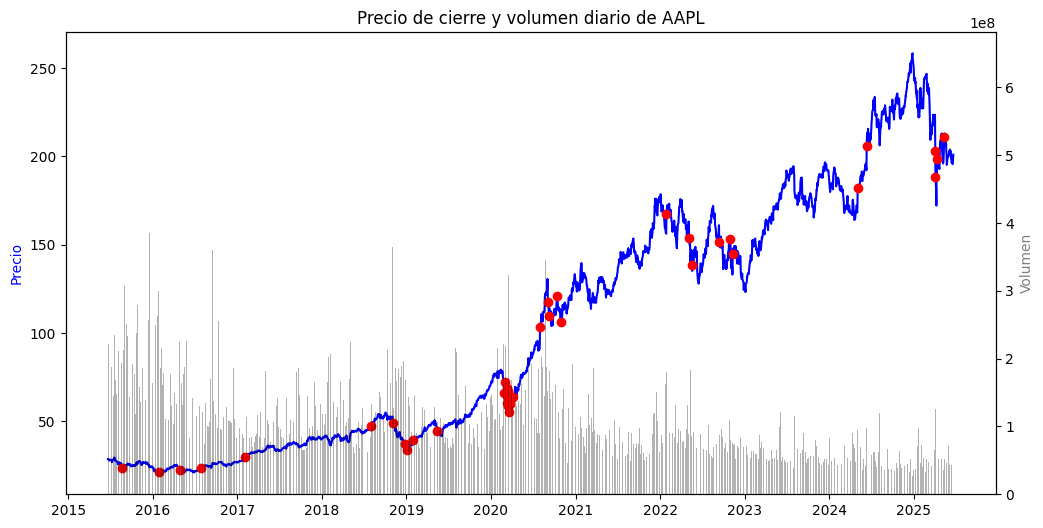

In [13]:


fig, ax1 = plt.subplots(figsize=(12, 6))

# Precio de cierre
ax1.plot(data.index, data["Adj Close"], color="blue", label="Precio de cierre")
ax1.set_ylabel("Precio", color="blue")
ax1.scatter(outliers_3sigma.index, outliers_3sigma["Adj Close"],
            color="red", label="Outliers ±3σ", zorder=5)

# Volumen en un eje secundario
ax2 = ax1.twinx()
ax2.bar(data.index, data["Volume"], color="black", alpha=0.3, label="Volumen")
ax2.set_ylabel("Volumen", color="gray")

plt.title("Precio de cierre y volumen diario de AAPL")
plt.show()


In [ ]:
corr = data[["LogReturn", "Volume"]].copy().iloc[1:]  # Saltea el primer valor NaN
corr["AbsReturn"] = corr["LogReturn"].abs()
print(corr[["AbsReturn", "Volume"]].corr())
